In [1]:
from instruction_reader import InstructionReader
from parse import parse_sexprs
import random

import tensorflow.compat.v1 as tf
import os
import pdb
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from tf_optimizer import TfOptimizer
from parse import parse_sexprs
from instruction_reader import InstructionReader

from util_graph_gen import *
from graph_generator import *


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)
tf.disable_v2_behavior()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import argparse
import pdb

from builder import build
from util import DEFAULTS
import copy

In [9]:
# Parse arguments
parser = argparse.ArgumentParser(description='Arguments for building a model that satisfies a set of geometry constraints')

# General arguments
parser.add_argument('--problem', '-p', action='store', type=str, help='Name of the file defining the set of constraints')
parser.add_argument('--dir', '-d', action='store', type=str, help='Directory containing problem files.')
parser.add_argument('--regularize_points', action='store', dest='regularize_points', type=float, default=DEFAULTS["regularize_points"])
parser.add_argument('--make_distinct', action='store', dest='make_distinct', type=float, default=DEFAULTS["make_distinct"])
parser.add_argument('--distinct_prob', action='store', dest='distinct_prob', type=float, default=DEFAULTS["distinct_prob"])
parser.add_argument('--min_dist', action='store', dest='min_dist', type=float, default=DEFAULTS["min_dist"])
parser.add_argument('--ndg_loss', action='store', dest='ndg_loss', type=float, default=DEFAULTS["ndg_loss"])

parser.add_argument('--n_models', action='store', dest='n_models', type=int, default=DEFAULTS['n_models'])
parser.add_argument('--n_tries', action='store', dest='n_tries', type=int, default=DEFAULTS['n_tries'])
parser.add_argument('--n_inits', action='store', dest='n_inits', type=int, default=DEFAULTS['n_inits'])
parser.add_argument('--verbosity', action='store', dest='verbosity', type=int, default=DEFAULTS['verbosity'])
parser.add_argument('--enforce_goals', dest='enforce_goals', action='store_true')
parser.add_argument('--plot_freq', action='store', dest='plot_freq', type=int, default=DEFAULTS['plot_freq'])
parser.add_argument('--loss_freq', action='store', dest='loss_freq', type=int, default=DEFAULTS['loss_freq'])
parser.add_argument('--losses_freq', action='store', dest='losses_freq', type=int, default=DEFAULTS['losses_freq'])

parser.add_argument('--unnamed_objects', dest='unnamed_objects', action='store_true')
parser.add_argument('--no_unnamed_objects', dest='unnamed_objects', action='store_false')
parser.set_defaults(unnamed_objects=True)

# Tensorflow arguments
parser.add_argument('--learning_rate', action='store', dest='learning_rate', type=float, default=DEFAULTS["learning_rate"])
parser.add_argument('--decay_steps', action='store', dest='decay_steps', type=float, default=DEFAULTS["decay_steps"])
parser.add_argument('--decay_rate', action='store', dest='decay_rate', type=float, default=DEFAULTS["decay_rate"])
parser.add_argument('--n_iterations', action='store', dest='n_iterations', type=int, default=DEFAULTS["n_iterations"])
parser.add_argument('--eps', action='store', dest='eps', type=float, default=DEFAULTS["eps"])

parser.add_argument('--experiment', dest='experiment', action='store_true')

parser.add_argument("--f", type=str, default='abc.def'),

args = parser.parse_args()
args = vars(args)


In [10]:
args['enforce_goals'] = True

In [11]:
from importlib import reload

import util_graph_gen
reload(util_graph_gen)
from util_graph_gen import *

import graph_generator
reload(graph_generator)
from graph_generator import *

Processing instructions...:   0%|          | 0/2 [00:00<?, ?it/s]

INPUT INSTRUCTIONS:
sample (P1 P2 P3 P4) polygon ()
assert (para (connecting P1 P2) (connecting P3 P4))


Sampling initializations...: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[     0]   0.129221889210 ||   0.100000
======== Print losses ==========
-- Losses --
  polygon-angle-sum                                  0.0008033350
  polygon-first-eq-last                              0.0403146667
  polygon-first-angle-eq-sampled                     0.0281016670
  para_(connecting P1 P2)_(connecting P3 P4)         0.0599931806
  points                                             0.0000090399
  distinct                                           0.0000000000
-- Goals --
-- NDGs --


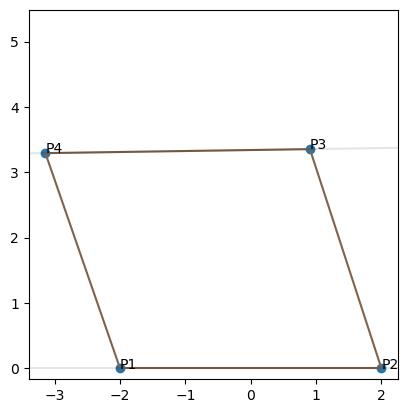

======== Print losses ==========
-- Losses --
  polygon-angle-sum                                  0.0000818692
  polygon-first-eq-last                              0.0007345543
  polygon-first-angle-eq-sampled                     0.0001095980
  para_(connecting P1 P2)_(connecting P3 P4)         0.0000505923
  points                                             0.0000074653
  distinct                                           0.0000000000
-- Goals --
-- NDGs --


Found 1 models


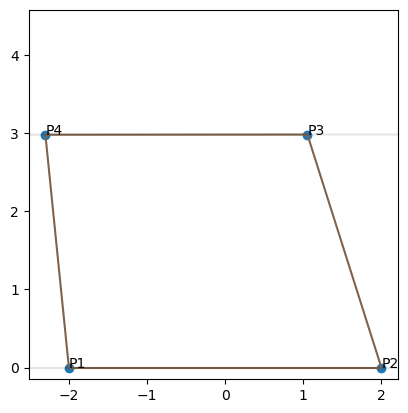

Processing instructions...:   0%|          | 0/3 [00:00<?, ?it/s]

######################## Lines drawn above ########################
['(param (P1 P2 P3 P4) polygon)', '(assert (para (line P1 P2) (line P3 P4)))']

INPUT INSTRUCTIONS:
sample (P1 P2 P3 P4) polygon ()
assert (para (connecting P1 P2) (connecting P3 P4))
sample (P5 P6 P7) acute-iso-tri (P6)


Sampling initializations...: 100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


[     0]   2.131810861032 ||   0.100000
======== Print losses ==========
-- Losses --
  polygon-angle-sum                                  0.0319453330
  polygon-first-eq-last                              0.0035633251
  polygon-first-angle-eq-sampled                     0.0040915682
  para_(connecting P1 P2)_(connecting P3 P4)         2.0921124583
  points                                             0.0000074735
  distinct                                           0.0000907029
-- Goals --
-- NDGs --


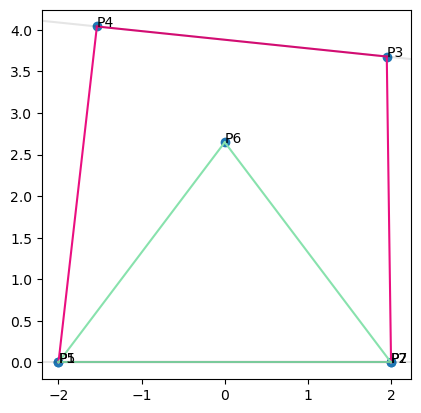

======== Print losses ==========
-- Losses --
  polygon-angle-sum                                  0.0001185337
  polygon-first-eq-last                              0.0002516720
  polygon-first-angle-eq-sampled                     0.0000439053
  para_(connecting P1 P2)_(connecting P3 P4)         0.0002625495
  points                                             0.0000064576
  distinct                                           0.0000907029
-- Goals --
-- NDGs --
DUP: P1 P5
[     0]   3.986525992614 ||   0.100000
======== Print losses ==========
-- Losses --
  polygon-angle-sum                                  0.0015119776
  polygon-first-eq-last                              0.0212163602
  polygon-first-angle-eq-sampled                     0.0015487820
  para_(connecting P1 P2)_(connecting P3 P4)         3.9621503202
  points                                             0.0000078497
  distinct                                           0.0000907029
-- Goals --
-- NDGs --


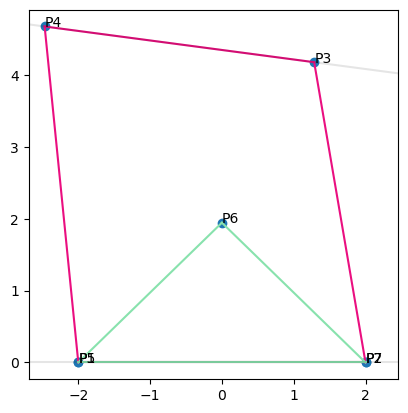

======== Print losses ==========
-- Losses --
  polygon-angle-sum                                  0.0000027639
  polygon-first-eq-last                              0.0003847881
  polygon-first-angle-eq-sampled                     0.0002533866
  para_(connecting P1 P2)_(connecting P3 P4)         0.0000455721
  points                                             0.0000062745
  distinct                                           0.0000907029
-- Goals --
-- NDGs --
DUP: P1 P5
[     0]   7.371242825608 ||   0.100000
======== Print losses ==========
-- Losses --
  polygon-angle-sum                                  0.0013004057
  polygon-first-eq-last                              0.0073303583
  polygon-first-angle-eq-sampled                     0.0037075135
  para_(connecting P1 P2)_(connecting P3 P4)         7.3588059148
  points                                             0.0000079304
  distinct                                           0.0000907029
-- Goals --
-- NDGs --


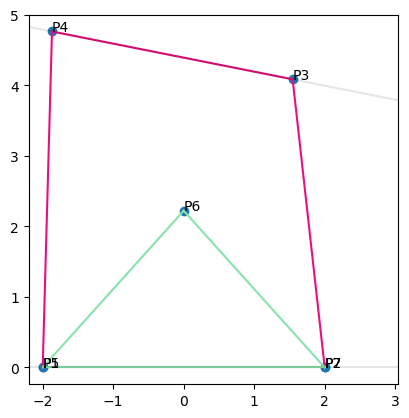

Processing instructions...:   0%|          | 0/3 [00:00<?, ?it/s]

======== Print losses ==========
-- Losses --
  polygon-angle-sum                                  0.0001321171
  polygon-first-eq-last                              0.0001171256
  polygon-first-angle-eq-sampled                     0.0000550504
  para_(connecting P1 P2)_(connecting P3 P4)         0.0001377616
  points                                             0.0000065750
  distinct                                           0.0000907029
-- Goals --
-- NDGs --
DUP: P1 P5


Found 0 models
INPUT INSTRUCTIONS:
sample (P1 P2 P3 P4) polygon ()
assert (para (connecting P1 P2) (connecting P3 P4))
define C1 ((excircle P4 P1 P2))


Sampling initializations...: 100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


[     0]   3.405609258739 ||   0.100000
======== Print losses ==========
-- Losses --
  polygon-angle-sum                                  0.0189058513
  polygon-first-eq-last                              0.0108844525
  polygon-first-angle-eq-sampled                     0.0241723080
  para_(connecting P1 P2)_(connecting P3 P4)         3.3516364467
  points                                             0.0000102002
  distinct                                           0.0000000000
-- Goals --
-- NDGs --


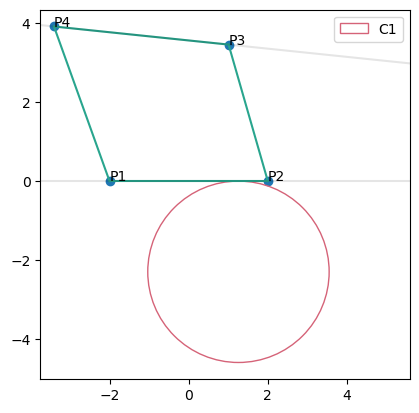

======== Print losses ==========
-- Losses --
  polygon-angle-sum                                  0.0000948047
  polygon-first-eq-last                              0.0001449388
  polygon-first-angle-eq-sampled                     0.0005500539
  para_(connecting P1 P2)_(connecting P3 P4)         0.0000107242
  points                                             0.0000091495
  distinct                                           0.0000000000
-- Goals --
-- NDGs --


Found 1 models


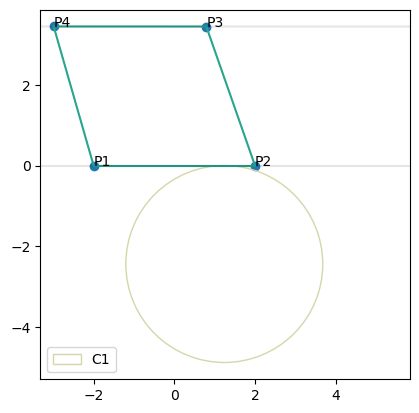

######################## Lines drawn above ########################
['(param (P1 P2 P3 P4) polygon)', '(assert (para (line P1 P2) (line P3 P4)))', '(define C1 circle (excircle P4 P1 P2))']



In [18]:
num_steps = 3
num_eval = 0
max_eval_attempt = round(math.sqrt(100))
readers, figs = generate_graph(args, num_steps, num_eval, max_eval_attempt=max_eval_attempt)

In [20]:
figs

[[Diagram(named_points={<primitives.Point object at 0x0000015298C13910>: TfPoint(x=-2.0, y=0.0), <primitives.Point object at 0x0000015298C13610>: TfPoint(x=2.0, y=0.0), <primitives.Point object at 0x0000015298C131F0>: TfPoint(x=1.05294425523612, y=2.9829974245209874), <primitives.Point object at 0x0000015298C13F10>: TfPoint(x=-2.300586980967596, y=2.9812191543946867)}, named_lines={}, named_circles={}, segments=[(TfPoint(x=-2.0, y=0.0), TfPoint(x=2.0, y=0.0)), (TfPoint(x=2.0, y=0.0), TfPoint(x=1.05294425523612, y=2.9829974245209874)), (TfPoint(x=1.05294425523612, y=2.9829974245209874), TfPoint(x=-2.300586980967596, y=2.9812191543946867)), (TfPoint(x=-2.300586980967596, y=2.9812191543946867), TfPoint(x=-2.0, y=0.0))], seg_colors=[array([0.50693726, 0.38332483, 0.2917936 ]), array([0.50693726, 0.38332483, 0.2917936 ]), array([0.50693726, 0.38332483, 0.2917936 ]), array([0.50693726, 0.38332483, 0.2917936 ]), array([0.27215674, 0.16288911, 0.49452177]), array([0.27215674, 0.16288911, 0.494

In [21]:
for item in readers:
    print(item)

    for pr_item in item.problem_lines:
        print(pr_item)
    print('')

(param (P1 P2 P3 P4) polygon)
(assert (para (line P1 P2) (line P3 P4)))
(param (P5 P6 P7) (acute-iso-tri P6) )

(param (P1 P2 P3 P4) polygon)
(assert (para (line P1 P2) (line P3 P4)))
(define C1 circle (excircle P4 P1 P2))



Processing instructions...:   0%|          | 0/3 [00:00<?, ?it/s]

INPUT INSTRUCTIONS:
sample (P1 P2 P3 P4) polygon ()
assert (para (connecting P1 P2) (connecting P3 P4))
define C1 ((excircle P4 P1 P2))


Sampling initializations...: 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


[     0]   0.174051504324 ||   0.100000
======== Print losses ==========
-- Losses --
  polygon-angle-sum                                  0.0053174497
  polygon-first-eq-last                              0.0843189029
  polygon-first-angle-eq-sampled                     0.0274234842
  para_(connecting P1 P2)_(connecting P3 P4)         0.0569809750
  points                                             0.0000106925
  distinct                                           0.0000000000
-- Goals --
-- NDGs --


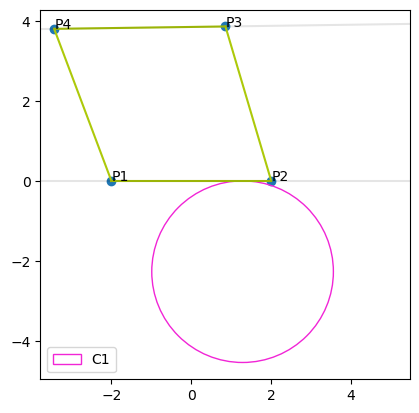

======== Print losses ==========
-- Losses --
  polygon-angle-sum                                  0.0000038636
  polygon-first-eq-last                              0.0006757976
  polygon-first-angle-eq-sampled                     0.0002091188
  para_(connecting P1 P2)_(connecting P3 P4)         0.0000896005
  points                                             0.0000079506
  distinct                                           0.0000000000
-- Goals --
-- NDGs --


Found 1 models


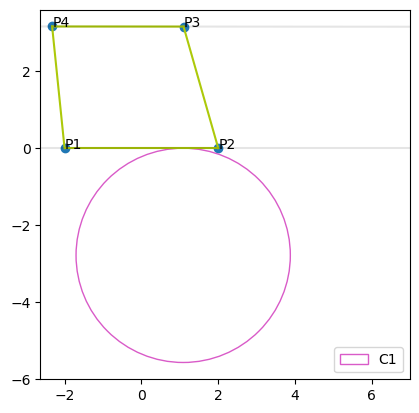

In [25]:
#lines = ['(param (P1 P2 P3) equi-tri )']

lines = readers[-1].problem_lines
reader = InstructionReader(lines)
fig = solve_draw(args, reader)

In [26]:
fig

[Diagram(named_points={<primitives.Point object at 0x0000015298AB89A0>: TfPoint(x=-2.0, y=0.0), <primitives.Point object at 0x0000015298AB86A0>: TfPoint(x=2.0, y=0.0), <primitives.Point object at 0x0000015298AB8430>: TfPoint(x=1.097282351077632, y=3.165457278500793), <primitives.Point object at 0x0000015298AB84C0>: TfPoint(x=-2.3233297831861908, y=3.167823659350835)}, named_lines={}, named_circles={<primitives.Circle object at 0x0000015298AB8FD0>: CircleNF(center=TfPoint(x=1.0877047115144933, y=-2.788594047271395), radius=2.7885940472713955)}, segments=[(TfPoint(x=-2.0, y=0.0), TfPoint(x=2.0, y=0.0)), (TfPoint(x=2.0, y=0.0), TfPoint(x=1.097282351077632, y=3.165457278500793)), (TfPoint(x=1.097282351077632, y=3.165457278500793), TfPoint(x=-2.3233297831861908, y=3.167823659350835)), (TfPoint(x=-2.3233297831861908, y=3.167823659350835), TfPoint(x=-2.0, y=0.0))], seg_colors=[array([0.67993521, 0.7890777 , 0.0383949 ]), array([0.67993521, 0.7890777 , 0.0383949 ]), array([0.67993521, 0.789077